# Differential Expression with limma-voom pipeline - Genes

In [1]:
suppressMessages({library(SummarizedExperiment)
                  library(data.table)
                  library(tidyverse)
                  library(memoise)
                  library(limma)
                  library(edgeR)
                  library(sva)})

## Prepare Data

## Functions

### General functions

In [2]:
# Function from jaffelab github
merge_rse_metrics <- function(rse) {
    stopifnot(is(rse, 'RangedSummarizedExperiment'))
    stopifnot(
        c('concordMapRate', 'overallMapRate', 'mitoRate', 'rRNA_rate',
          'totalAssignedGene', 'numMapped', 'numReads', 'numUnmapped',
          'mitoMapped', 'totalMapped') %in%
            colnames(SummarizedExperiment::colData(rse))
    )

    stopifnot(all(sapply(c(
        'concordMapRate', 'overallMapRate', 'mitoRate', 'rRNA_rate',
        'totalAssignedGene', 'numMapped', 'numReads', 'numUnmapped',
        'mitoMapped', 'totalMapped'), function(var) {
            is(colData(rse)[, var], 'List')
        })
    ))

    rse$concordMapRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$concordMapRate, rse$numReads)
    rse$overallMapRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$overallMapRate, rse$numReads)
    rse$mitoRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$mitoRate, rse$numMapped)
    rse$rRNA_rate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$rRNA_rate, rse$numMapped)
    rse$totalAssignedGene = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$totalAssignedGene, rse$numMapped)

    rse$numMapped = sapply(rse$numMapped, sum)
    rse$numReads = sapply(rse$numReads, sum)
    rse$numUnmapped = sapply(rse$numUnmapped, sum)
    rse$mitoMapped = sapply(rse$mitoMapped, sum)
    rse$totalMapped = sapply(rse$totalMapped, sum)
    return(rse)
}

In [3]:
save_volcanoPlot <- function(top, label, dirname){
    pdf(file=paste0(dirname, "/volcanoPlot_", label, ".pdf"), 8, 6)
    with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
    with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                              pch=20, col='red', cex=0.6))
    with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                              pch=20, col='orange', cex=0.6))
    with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
         points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))
    dev.off()
}

save_MAplot <- function(top, label, dirname){
    pdf(file=paste0(dirname, "/MAplot_", label, ".pdf"), 8, 6)
    with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
    with(subset(top, adj.P.Val<0.05),
         points(AveExpr, logFC, col="red", pch=20, cex=0.5))
    dev.off()
}

extract_de <- function(contrast, label, efit, seed_int){
    dirname = paste0("permutation_", stringr::str_pad(seed_int, 2, pad = "0"))
    top <- topTable(efit, coef=contrast, number=Inf, sort.by="P")
    top <- top[order(top$P.Value), ]
    top.fdr <- top %>% filter(adj.P.Val<=0.05)
    print(paste("Comparison for:", label))
    print(paste('There are:', dim(top.fdr)[1], 'DE features!'))
    fwrite(top, 
           file=paste0(dirname, "/diffExpr_", label, "_full.txt"), 
           sep='\t', row.names=TRUE)
    fwrite(top.fdr, 
           file=paste0(dirname, "/diffExpr_", label, "_FDR05.txt"), 
           sep='\t', row.names=TRUE)
    save_volcanoPlot(top, label, dirname)
    save_MAplot(top, label, dirname)
}


### Cached functions

In [4]:
load_counts <- function(){
    counts_file = paste0("/ceph/projects/v3_phase3_paper/inputs/phase2/_m/count_data/",
                         "hippo_brainseq_phase2_hg38_rseGene_merged_n447.rda")
    load(counts_file)
    rse_df = rse_gene
    return(rse_df)
}
memCounts <- memoise(load_counts)

get_random_samples <- function(seed_int, new_dir=TRUE){
    set.seed(seed_int + 113) # seed for reproducibility
    dirname = paste0("permutation_", stringr::str_pad(seed_int, 2, pad = "0"))
    if(new_dir){
        dir.create(dirname)
    }
    rse_df <- memCounts()
    keepIndex = which((rse_df$Dx %in% c("Control", "Schizo")) & 
                      (rse_df$Age > 17) & (rse_df$Sex == "M") & 
                      (rse_df$Race %in% c("AA", "CAUC")))
    snames = sample(keepIndex, 121, replace=FALSE) # subsampling to Female N (sample size)
    return(snames)
}
memSamples <- memoise(get_random_samples)

get_MDS_genotypes <- function(){
    mds_file = paste0("/ceph/projects/v3_phase3_paper/inputs/genotypes/to_brnum/", 
                      "merge/to_plink/mds/_m/merged.mds")
    mds = fread(mds_file) %>% 
        rename("snpPC1"="C1", "snpPC2"="C2", "snpPC3"="C3", 
               "snpPC4"="C4", "snpPC5"="C5") %>%
        mutate_if(is.character, as.factor)
    return(mds)
}
memMDS <- memoise(get_MDS_genotypes)

prep_data <- function(seed_int){
    rse_df <- memCounts()
    keepIndex <- memSamples(seed_int)
    rse_df = rse_df[, keepIndex]
    rse_df$Dx = factor(rse_df$Dx, levels = c("Control", "Schizo"))
    rse_df$Sex <- factor(rse_df$Sex)
    rse_df <- merge_rse_metrics(rse_df)
    rse_df$ERCCsumLogErr <- mapply(function(r, n) {
        sum(r * n)/sum(n)
    }, rse_df$ERCCsumLogErr, rse_df$numReads)
    colData(rse_df)$RIN = sapply(colData(rse_df)$RIN,"[",1)
    rownames(colData(rse_df)) <- sapply(strsplit(rownames(colData(rse_df)), "_"), "[", 1)
    pheno = colData(rse_df) %>% as.data.frame %>% 
        inner_join(memMDS(), by=c("BrNum"="FID"))
    # Generate DGE list
    x <- DGEList(counts=assays(rse_df)$counts, 
                 genes=rowData(rse_df), 
                 samples=pheno)
    # Filter by expression
    design0 <- model.matrix(~Dx, data=x$samples)
    keep.x <- filterByExpr(x, design=design0)
    x <- x[keep.x, , keep.lib.sizes=FALSE]
    print(paste('There are:', sum(keep.x), 'features left!', sep=' '))
    # Normalize library size
    x <- calcNormFactors(x, method="TMM")
    return(x)
}
memo_prepData <- memoise(prep_data)

SVA_model <- function(seed_int){
    x <- memo_prepData(seed_int)
    # Design matrix
    mod = model.matrix(~Dx + Age + mitoRate + rRNA_rate + RIN + 
                       totalAssignedGene + overallMapRate + ERCCsumLogErr + 
                       snpPC1 + snpPC2 + snpPC3, data=x$samples)
    colnames(mod) <- gsub("Dx", "", colnames(mod))
    colnames(mod) <- gsub("\\(Intercept\\)", "Intercept", colnames(mod))
    # Calculated SVs
    null.model = mod %>% as.data.frame %>% select(-c("Schizo")) %>% as.matrix
    n.sv <- num.sv(x$counts, mod, method="be")
    svobj <- svaseq(x$counts, mod, null.model, n.sv=n.sv)
    if(svobj$sv == 0){
        modQsva <- mod
    } else {
        modQsva <- cbind(mod, svobj$sv)
        len.d <- length(colnames(modQsva))
        colnames(modQsva)[((len.d - n.sv)+1):len.d] <- make.names(paste0("sv",1:n.sv))
    }
    return(modQsva)
}
memo_svaModel <- memoise(SVA_model)

get_voom <- function(seed_int){
    ### Preform voom
    x <- memo_prepData(seed_int)
    modQsva <- memo_svaModel(seed_int)
    v <- voom(x[, rownames(modQsva)], modQsva, plot=TRUE)
    return(v)
}
memo_voom <- memoise(get_voom)

cal_res <- function(seed_int){
    ### Calculate residuals
    v <- memo_voom(seed_int)
    null_model <- v$design %>% as.data.frame %>% select(-c("Schizo")) %>% as.matrix
    fit_res <- lmFit(v, design=null_model)
    res = v$E - ( fit_res$coefficients %*% t(null_model) )
    res_sd = apply(res, 1, sd)
    res_mean = apply(res, 1, mean)
    res_norm = (res - res_mean) / res_sd
    dirname = paste0("permutation_", stringr::str_pad(seed_int, 2, pad = "0"))
    write.table(res_norm, file=paste0(dirname, '/residualized_expression.tsv'), 
                sep="\t", quote=FALSE)
}
memo_res <- memoise(cal_res)

fit_voom <- function(seed_int){
    v <- memo_voom(seed_int)
    modQsva <- memo_svaModel(seed_int)
    fit0 <- lmFit(v, modQsva)
    contr.matrix <- makeContrasts(CtrlvsSZ = Schizo,  
                                  levels=colnames(modQsva))
    fit <- contrasts.fit(fit0, contrasts=contr.matrix)
    esv <- eBayes(fit)
    return(esv)
}
memo_efit <- memoise(fit_voom)

## Differential Expression Analysis

[1] "There are: 22488 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

Warning message in if (svobj$sv == 0) {:
“the condition has length > 1 and only the first element will be used”


[1] "Comparison for: CtrlvsSZ"
[1] "There are: 2 DE features!"
[1] "There are: 22615 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

Warning message in if (svobj$sv == 0) {:
“the condition has length > 1 and only the first element will be used”


[1] "Comparison for: CtrlvsSZ"
[1] "There are: 23 DE features!"
[1] "There are: 22909 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

Warning message in if (svobj$sv == 0) {:
“the condition has length > 1 and only the first element will be used”


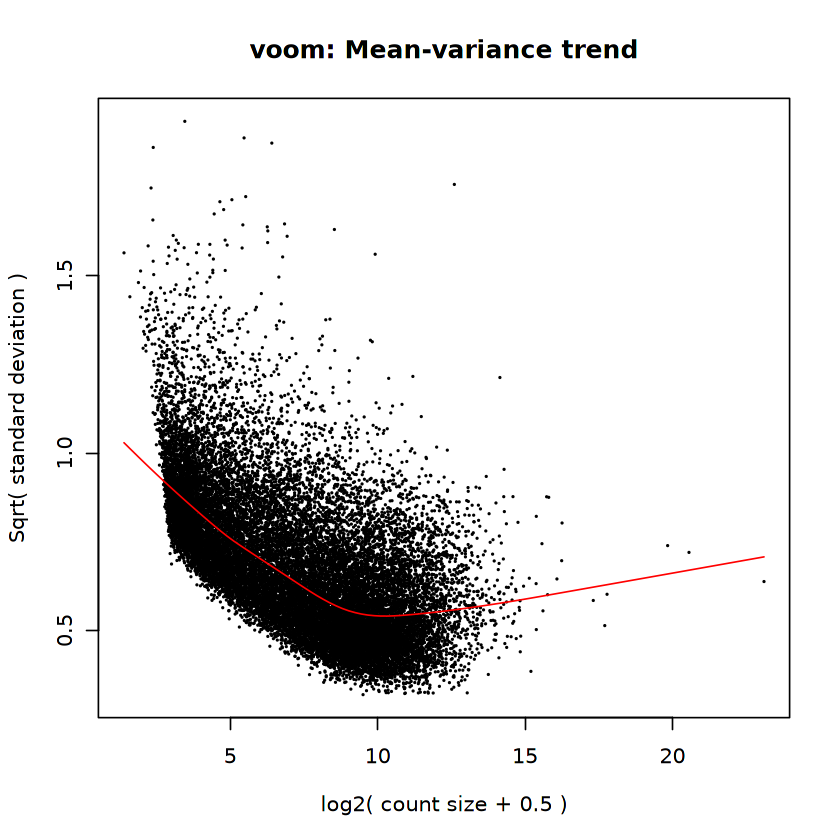

[1] "Comparison for: CtrlvsSZ"
[1] "There are: 0 DE features!"
[1] "There are: 22579 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

Warning message in if (svobj$sv == 0) {:
“the condition has length > 1 and only the first element will be used”


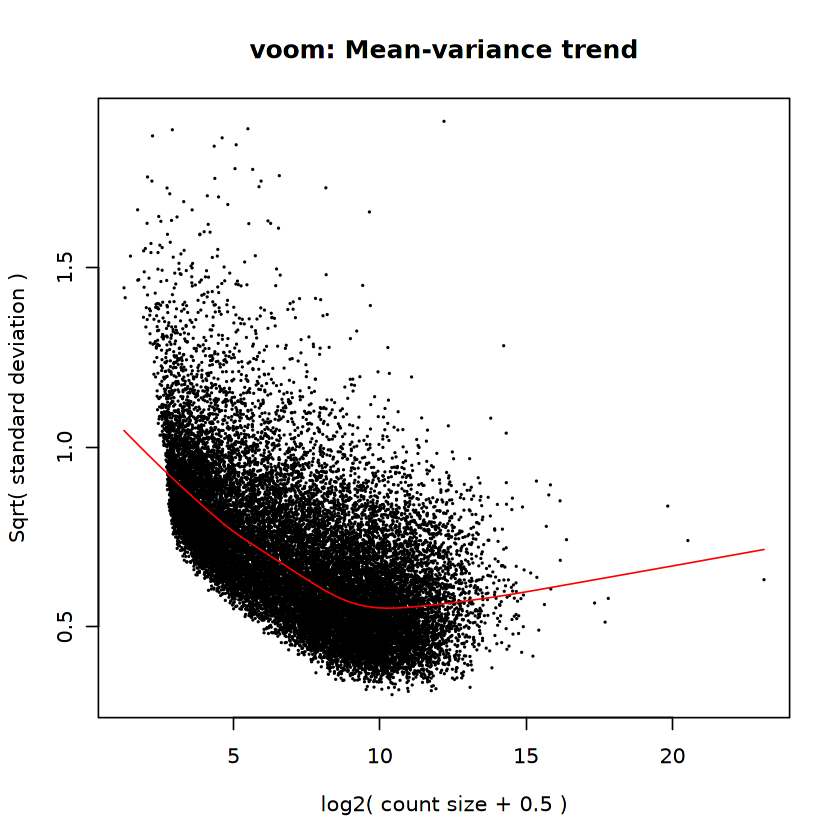

[1] "Comparison for: CtrlvsSZ"
[1] "There are: 92 DE features!"
[1] "There are: 22676 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

Warning message in if (svobj$sv == 0) {:
“the condition has length > 1 and only the first element will be used”


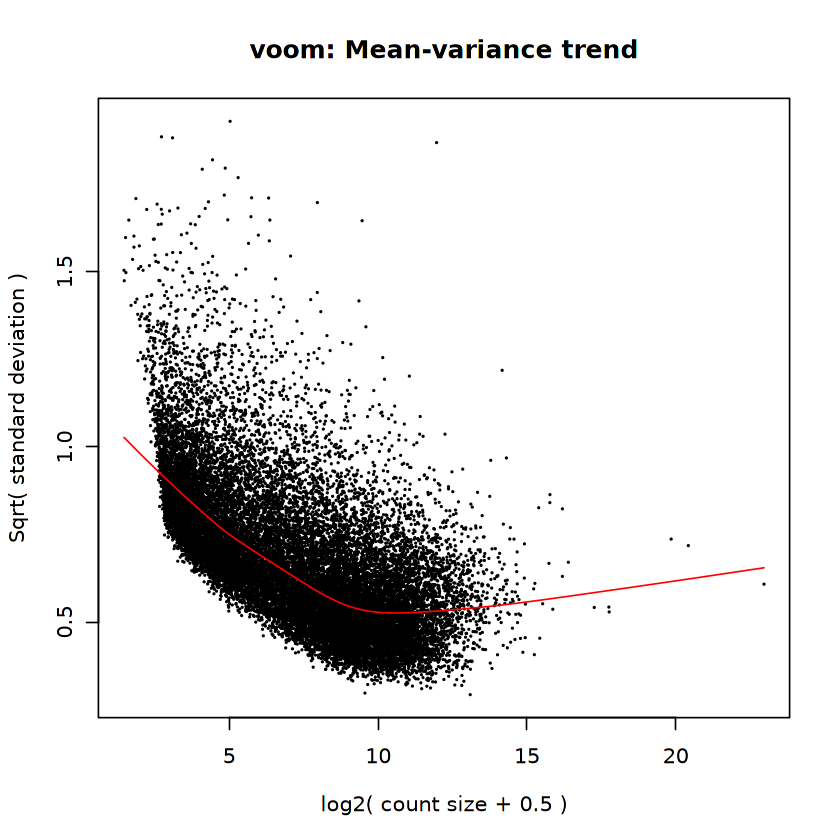

[1] "Comparison for: CtrlvsSZ"
[1] "There are: 0 DE features!"
[1] "There are: 22648 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

Warning message in if (svobj$sv == 0) {:
“the condition has length > 1 and only the first element will be used”


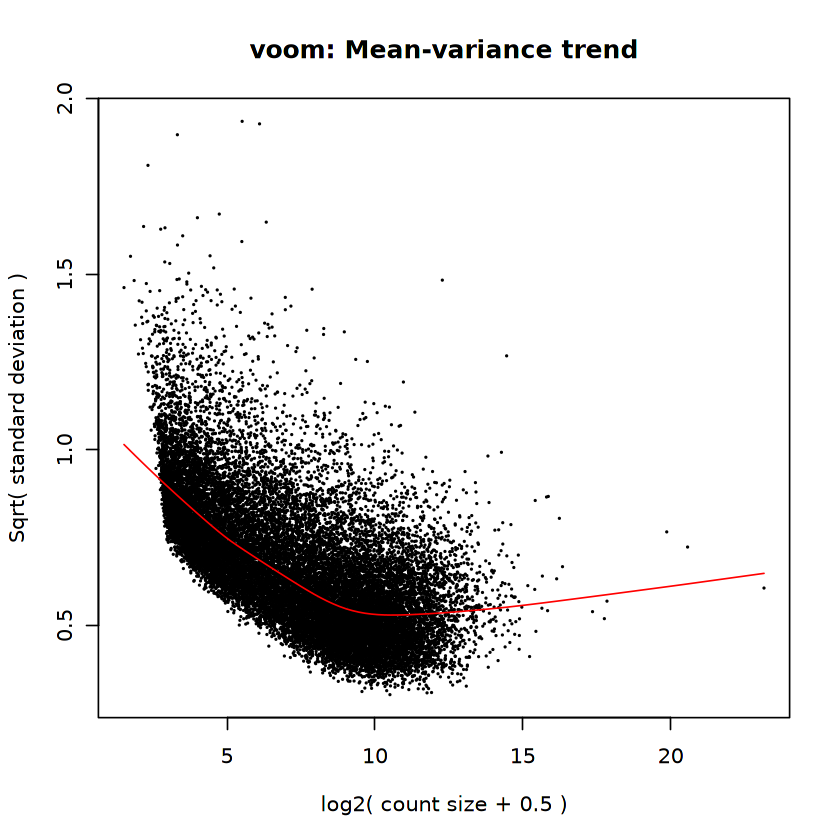

[1] "Comparison for: CtrlvsSZ"
[1] "There are: 0 DE features!"
[1] "There are: 22587 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

Warning message in if (svobj$sv == 0) {:
“the condition has length > 1 and only the first element will be used”


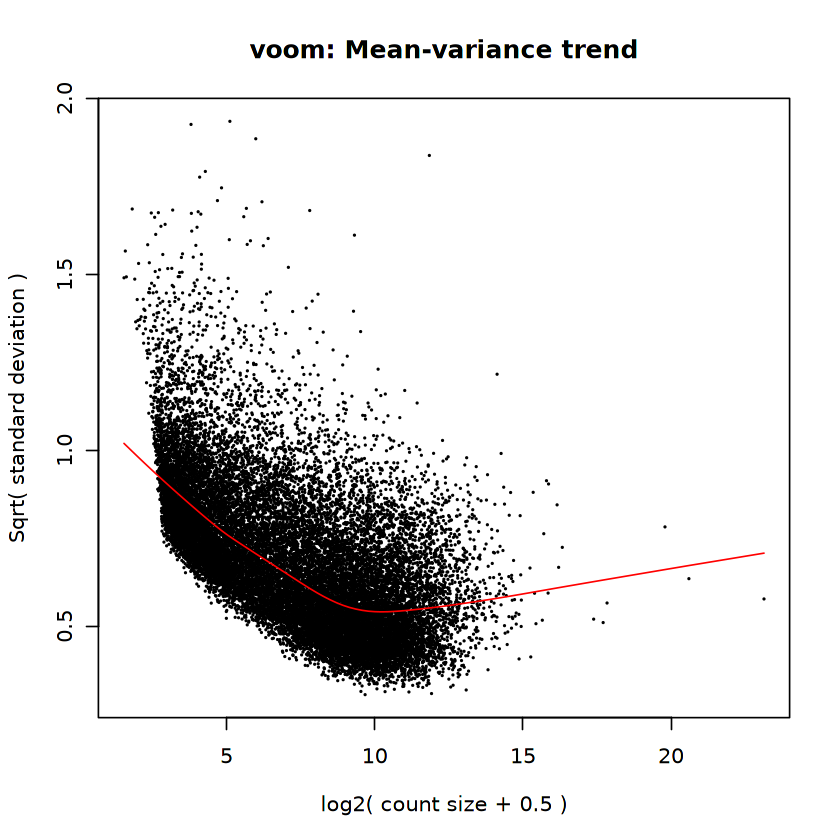

[1] "Comparison for: CtrlvsSZ"
[1] "There are: 0 DE features!"
[1] "There are: 22884 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

Warning message in if (svobj$sv == 0) {:
“the condition has length > 1 and only the first element will be used”


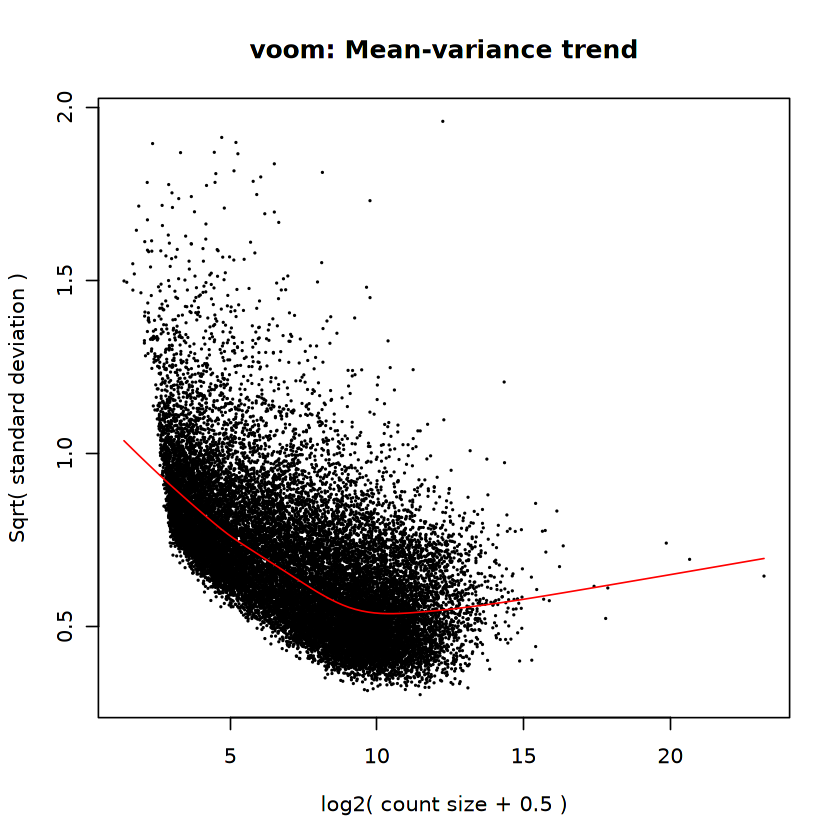

[1] "Comparison for: CtrlvsSZ"
[1] "There are: 0 DE features!"
[1] "There are: 22440 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

Warning message in if (svobj$sv == 0) {:
“the condition has length > 1 and only the first element will be used”


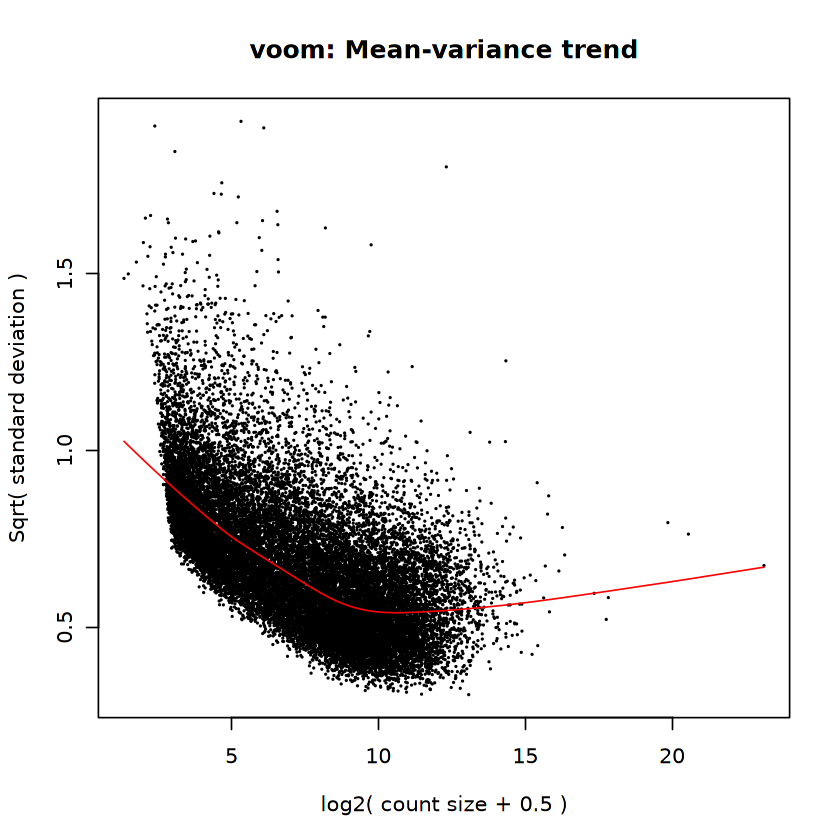

[1] "Comparison for: CtrlvsSZ"
[1] "There are: 1 DE features!"
[1] "There are: 23017 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

Warning message in if (svobj$sv == 0) {:
“the condition has length > 1 and only the first element will be used”


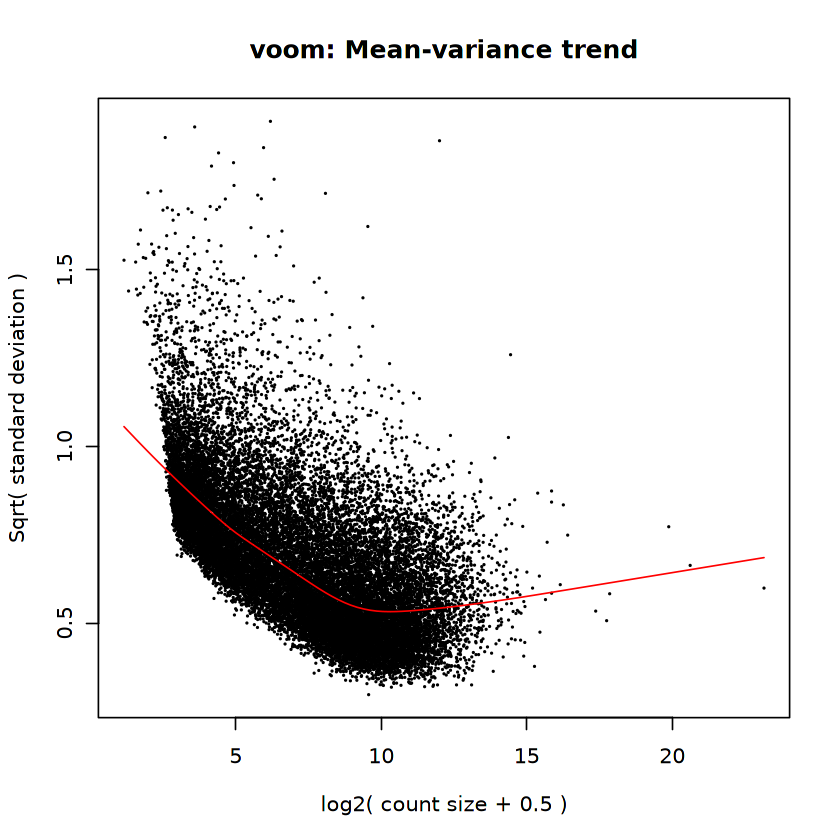

[1] "Comparison for: CtrlvsSZ"
[1] "There are: 20 DE features!"


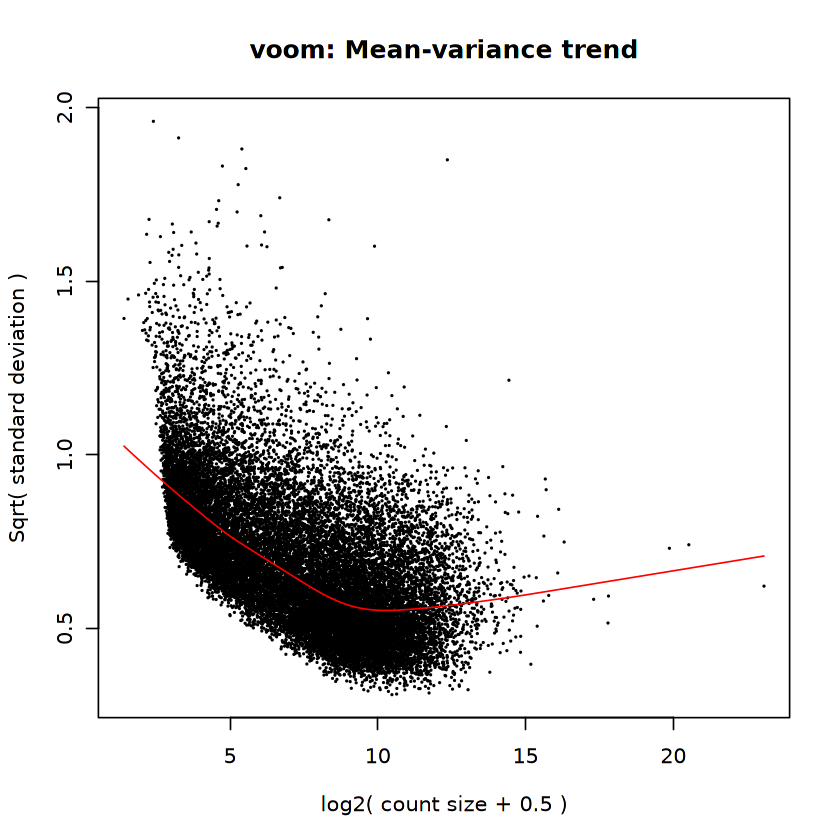

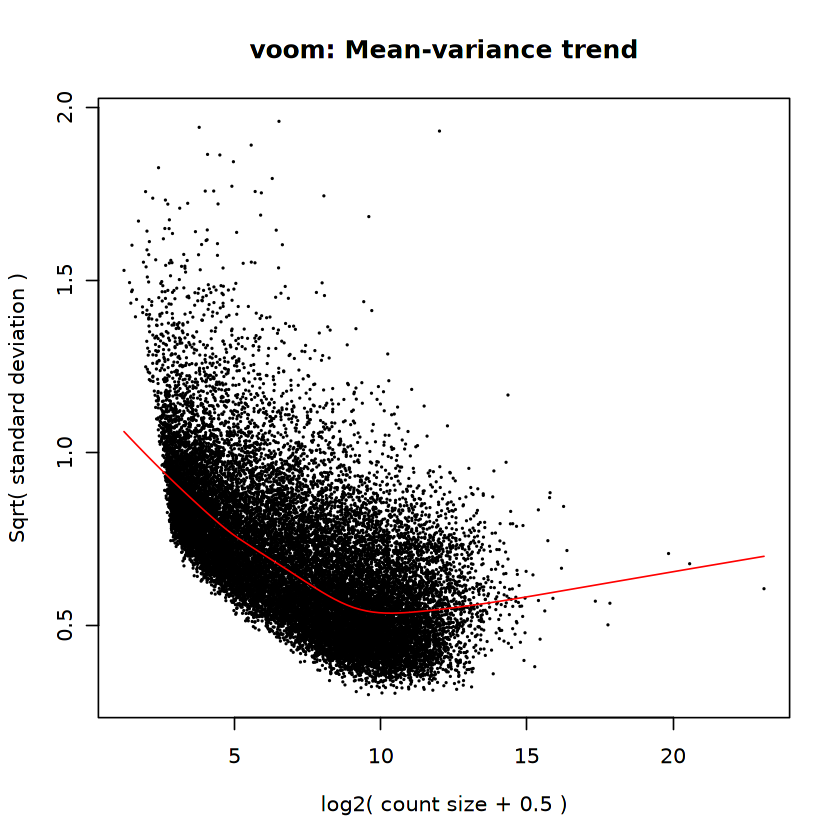

In [5]:
for(seed_int in seq(1, 10)){
    # Preform voom
    v <- memo_voom(seed_int)
    dirname = paste0("permutation_", stringr::str_pad(seed_int, 2, pad = "0"))
    save(v, file=paste0(dirname,'/voomSVA.RData'))
    # Fit model and apply eBayes
    efit = memo_efit(seed_int)
    # Save differential expression
    extract_de(1, "CtrlvsSZ", efit, seed_int)
    # Calculate residuals
    memo_res(seed_int)
}

## Reproducibility Information

In [6]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-07-13 15:40:43 EDT"

    user   system  elapsed 
2545.168  632.222  559.317 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-07-13                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package              * version  date       lib source        
 annotate               1.68.0   2020-10-27 [1] Bioconductor  
 AnnotationDbi          1.52.0   2020-10-27 [1] Bioconductor  
 assertthat             0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports              1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc              0.1-3    2015-07-28 [1] CRAN (R 